In [ ]:
# Written By Hanz Vora (mostly)
# VALUES IN USD

In [ ]:
#import yahoo finance
!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 5.5MB 19.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=02a4f149cbbc365adca72387c0018f83a06b87afa1b458932e4ed67d117bfb7e
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
# GCP Deployment

#!gcloud init

#!gcloud ml-engine models list

In [ ]:
import pandas as pd
import io
import numpy as np
from tqdm import tqdm

# from google.colab import files
# uploaded = files.upload()

In [ ]:
TICKER = 'TSLA'

In [ ]:
# create ticker object
tick = yf.Ticker(TICKER)

In [ ]:
# df = pd.read_csv(io.StringIO(uploaded['MSFT_data.csv'].decode('utf-8')))

In [ ]:
# get stock data
df = tick.history(period="5y")

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-11-19,44.108002,45.237999,44.060001,44.360001,12522000,0,0.0
2015-11-20,44.698002,45.000000,42.716000,44.001999,22003500,0,0.0
2015-11-23,43.470001,43.835999,42.936001,43.549999,12631000,0,0.0
2015-11-24,43.074001,44.200001,43.000000,43.650002,12401500,0,0.0
2015-11-25,44.268002,46.166000,44.076000,45.928001,19954000,0,0.0


In [ ]:
# df['date'] =  pd.to_datetime(df['date'], format='%Y-%m-%d')
# df.set_index('date', inplace = True)

In [ ]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-11-12,415.049988,423.000000,409.519989,411.760010,19855100,0,0.0
2020-11-13,410.850006,412.529999,401.660004,408.500000,19771100,0,0.0
2020-11-16,408.929993,412.450012,404.089996,408.089996,26838600,0,0.0
2020-11-17,460.170013,462.000000,433.010010,441.609985,61014500,0,0.0
2020-11-18,448.350006,496.000000,443.500092,486.640015,78044026,0,0.0


In [ ]:
# Split on dates needs to be changed to random sample (not currently using this)
# test_split = '2017-01-01'
# train = df[:test_split]
# test = df[test_split:]

In [ ]:
# Checking test split size
# len(test)/(len(train)+len(test))*100

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import random
from collections import deque
import math
import random

# Agent class which contains most functionality for trading bot
class Agent:
    
    def __init__(self):

        # number of possible actions (buy,sell,hold)
        self.actions = 3 
        # list of positions currently held          
        self.curr_positions = []
        # gamma used in deep q learning equation
        self.gamma = 0.95
        # queue holding log of all actions taken
        self.trade_log = deque(maxlen = 5000)
        # instance of the network model
        self.model = self._model()
        self.first = True

        # beta used for random value
        self.beta = 1.0

        # decay factor for trade randomness
        self.decay = 0.995

        # minimum random value
        self.min = 0.01

    # build model here
    # need to experiment with different network structure
    def _model(self):
        model = Sequential()
        model.add(Dense(units = 128, activation = "relu"))
        model.add(Dense(units = self.actions))
        model.compile(loss = 'MSE', optimizer = 'SGD')
        return model

    # update trade/action history with attributes (state, action, reward, next_state)
    def history(self, attributes):
        self.trade_log.append(attributes)

    # run the model to predict an action given a state
    def take_action(self, state):

        # first day must be a buy
        if self.first:
          self.first = False
          return 1

        # decaying randomness applied to first few trades
        if random.random() <= self.beta:
          return random.randrange(self.actions)

        proba = self.model.predict(state)
        # argmax of the probability vector (buy,sell,hold)
        return np.argmax(proba[0])

    def train(self, batch_size):

        # take a sample of previous states and actions for the current batch
        mini_batch = random.sample(self.trade_log, batch_size)
        
        x_train = []
        y_train = []
        
        # iterate through mini batch
        for state, action, reward, next_state in mini_batch:
            # deep q learning equation ** not too sure about this
            target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
        
            # updating q values given prediction on current state
            q_values = self.model.predict(state)
            # q_values[0] holds the target for each action which is updated here with a new target
            q_values[0][action] = target
        
            
            x_train.append(state[0])
            y_train.append(q_values[0])
        
        # refit the model
        loss = self.model.fit(np.array(x_train), np.array(y_train), epochs = 1).history['loss'][0]

        # if beta is larger than min, apply decay to beta
        if self.beta > self.min:
          self.beta *= self.decay

        return loss

In [ ]:
# activation sigmoid function called by get_state
def sigmoid(x):
  if x < 0:
      return 1 - 1 / (1 + math.exp(x))
  return 1 / (1 + math.exp(-x))

In [ ]:
""" data: dataset of stock prices and dates 

    t: current day (starting at day 0 to n = size of data - 1)
    
    n_days: window to use for state representation
"""
def get_state(data, t, n_days):

    # identify the index of n_days prior to today + 1
    d = t - n_days + 1

    # take a block of data from n_days prior to current day + 1 if they exist
    # if days do not exist in history, fill prior days with value of first day
    if d >= 0:
      block = data[d: t + 1]
    else:
      block = -d * [data[0]] + data[0: t + 1]
    res = []
    # iterate through block
    for i in range(n_days - 1):
        # append sigmoid function value for given stock price at day i + 1 - day i
        res.append(sigmoid(block[i + 1] - block[i]))
    # return an np array (state representation) for given window
    return np.array([res])

In [ ]:
# train an agent object given a set of data
def train_model(agent, data):

  # total profit
  profit = 0
  days = 0
  curr_holdings = 0
  dividend = 0
  # profit history
  profit_hist = []

  # window of days
  window = 10

  # current positions held
  agent.curr_positions = []

  # loss values
  lis_loss = []

  trade_log = []

  # get current state representation given window of days
  state = get_state(data, 0, window)

  # iterate through entire dataset or 'days'
  for i in range(len(data)-1):        
    reward = 0
    # get next state for i + 1 (next day)
    next_state = get_state(data, i + 1, window)

    # predict an action given a state
    action = agent.take_action(state)

    # buy if action is 1, append the position and price to current positions
    if action == 1:
      agent.curr_positions.append(data[i])
      trade_log.append('Buy')
      curr_holdings += 1

    # sell if action is 2, and we are holding a position
    elif action == 2 and len(agent.curr_positions) > 0:
      # pop from queue to determine price we bought at
      bought_price = agent.curr_positions.pop(0)
      # profit calculation
      delta = data[i] - bought_price
      # reward is equal to profit
      reward = delta
      profit += delta
      # update the profit history
      profit_hist.append(profit)
      trade_log.append('Sell')
      curr_holdings -= 1

    # HOLD (do nothing)
    else:
      trade_log.append('Hold')

    # dividend calculation
    days += 1
    if days % 91 == 0:
      dividend += curr_holdings* 0.50
    # append relevant information to the agent history (to be used for training)
    agent.history((state, action, reward, next_state))

    # if the trade log has bassed the batch size, retrain the agent
    if len(agent.trade_log) % 64 == 0:
      loss = agent.train(64)
      lis_loss.append(loss)

    # our new state is the next state
    state = next_state

  return (profit,lis_loss, profit_hist, trade_log, curr_holdings, dividend)

In [ ]:
trader = Agent()
profit, loss, profit_hist, trade_log, curr_holdings, dividend = train_model(trader, list(df.Close))

2/2 [==============================] - 0s 1ms/step - loss: 34.6966


In [ ]:
# not up to date
dividend

46.5

In [ ]:
curr_holdings

4

In [ ]:
profit

2445.408136367798

In [ ]:
import matplotlib.pyplot as plt

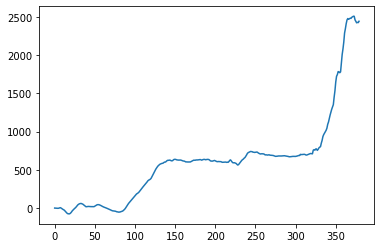

In [ ]:
plt.plot(profit_hist)

In [ ]:
trade_log

['Buy',
 'Hold',
 'Hold',
 'Sell',
 'Hold',
 'Buy',
 'Hold',
 'Buy',
 'Buy',
 'Hold',
 'Hold',
 'Buy',
 'Sell',
 'Buy',
 'Sell',
 'Hold',
 'Buy',
 'Buy',
 'Hold',
 'Buy',
 'Hold',
 'Sell',
 'Sell',
 'Sell',
 'Hold',
 'Buy',
 'Sell',
 'Hold',
 'Sell',
 'Buy',
 'Hold',
 'Buy',
 'Hold',
 'Buy',
 'Hold',
 'Buy',
 'Buy',
 'Sell',
 'Hold',
 'Buy',
 'Buy',
 'Hold',
 'Buy',
 'Hold',
 'Hold',
 'Sell',
 'Sell',
 'Sell',
 'Buy',
 'Buy',
 'Hold',
 'Sell',
 'Buy',
 'Sell',
 'Sell',
 'Sell',
 'Sell',
 'Buy',
 'Buy',
 'Hold',
 'Buy',
 'Hold',
 'Hold',
 'Buy',
 'Buy',
 'Buy',
 'Buy',
 'Sell',
 'Sell',
 'Buy',
 'Buy',
 'Hold',
 'Hold',
 'Sell',
 'Buy',
 'Hold',
 'Sell',
 'Sell',
 'Hold',
 'Buy',
 'Hold',
 'Sell',
 'Hold',
 'Buy',
 'Sell',
 'Hold',
 'Sell',
 'Sell',
 'Hold',
 'Sell',
 'Hold',
 'Hold',
 'Sell',
 'Hold',
 'Sell',
 'Buy',
 'Buy',
 'Buy',
 'Buy',
 'Sell',
 'Buy',
 'Buy',
 'Sell',
 'Sell',
 'Sell',
 'Sell',
 'Buy',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Sell',
 'Sell',
 'Buy',
 'Sell